# Estimate generation v2

Global Power Plant Database; World Resources Institute

- Use advanced models for generation estimation in the Global Power Plant Database.
- Primary model is a two-hidden-layer neural network.

In [1]:
# import what we'll need and set parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import io
import pydot

GPPD_FILENAME = '../../output_database/global_power_plant_database.csv'
WEIGHTS_FILE = "model/estimate_generation.h5"
VALIDATION_FRACTION = 0.2


Using TensorFlow backend.


In [2]:
# set up fuel colors

fuel_color = { 'Biomass':'#33a02c',
                'Coal':'sienna',
                'Cogeneration':'#e31a1c',
                'Gas':'#a6cee3',
                'Geothermal':'#b2df8a',
                'Hydro':'#1f78b4',
                'Nuclear':'#6a3d9a',
                'Oil':'black',
                'Other':'gray',
                'Petcoke':'#fb9a99',
                'Solar':'#ffff99',
                'Storage':'#ff1010',   # need better color
                'Waste':'#fdbf6f',
                'Wave_and_Tidal':'#b15928',
                'Wind':'#ff7f00'
}

In [3]:
# read in database
df = pd.read_csv(GPPD_FILENAME)
df.head()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,fuel1,fuel2,fuel3,...,owner,source,url,geolocation_source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,estimated_generation_gwh
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.00,32.3220,65.1190,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.00,34.5560,69.4787,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.00,34.6410,69.7170,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,Nangarhar (Darunta) Hydroelectric Power Plant ...,GEODB0040536,11.55,34.4847,70.3633,Hydro,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,Northwest Kabul Power Plant Afghanistan,GEODB0040540,42.00,34.5638,69.1134,Gas,NaN,NaN,...,NaN,GEODB,http://globalenergyobservatory.org,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# show count for number of valid entries in each column
df.count()

country                     25657
country_long                25657
name                        25637
gppd_idnr                   25657
capacity_mw                 25657
latitude                    25657
longitude                   25657
fuel1                       25657
fuel2                        1670
fuel3                         295
fuel4                         107
commissioning_year          13933
owner                       17157
source                      25657
url                         25657
geolocation_source          25657
year_of_capacity_data       16065
generation_gwh_2013           371
generation_gwh_2014           386
generation_gwh_2015           887
generation_gwh_2016          8326
estimated_generation_gwh    24633
dtype: int64

In [5]:
# prepare data for training
# don't include plants with zero generation (min capacity factor = 0.01)
# (may simply result from missing data)
# should address this issue in the future!

MIN_CAPACITY_FACTOR = 0.01
MAX_CAPACITY_FACTOR = 1.0

# convert string-type columns to categories (assume no NaNs in these columns)
factorized_countries,country_key = df['country'].astype('category').factorize()
df['country_factorized'] = factorized_countries
factorized_fuel1,fuel1_key = df['fuel1'].astype('category').factorize()
df['fuel1_factorized'] = factorized_fuel1

# create new data frame with relevant predictor variable (X) columns and 2016 generation
# clean data frame by removing NaNs
X_columns = ['country_factorized','capacity_mw','latitude','longitude','commissioning_year','fuel1_factorized']
df_clean = df[X_columns + ['generation_gwh_2016']].dropna(how='any')

# convert 2016 generation into capacity factor and remove rows with erroneous capacity factors
df_clean['capacity_factor'] = df_clean.apply(lambda row:row['generation_gwh_2016']/(24.0*365.0*0.001*row['capacity_mw']),axis=1)
df_clean = df_clean[df_clean.capacity_factor >= MIN_CAPACITY_FACTOR]
df_clean = df_clean[df_clean.capacity_factor <= MAX_CAPACITY_FACTOR]

# create np arrays from data frame
X_data = df_clean[X_columns].as_matrix()
y_column = ['capacity_factor']
y_data = df_clean[y_column].as_matrix()

# show results
print(X_data)
print(y_data)
print(len(X_data))
print(len(y_data))

[[    8.       289.        47.2078    11.0057  1981.         0.    ]
 [    8.       500.        47.2696    10.9678  1981.         0.    ]
 [   55.      1480.        53.8506     9.345   1986.         5.    ]
 ..., 
 [  157.        28.        14.3611   108.7203  2014.         0.    ]
 [  157.        19.5       12.1526   108.3787  2010.         0.    ]
 [  157.        30.        15.86     107.6538  2009.         0.    ]]
[[ 0.04692255]
 [ 0.02934475]
 [ 0.81033799]
 ..., 
 [ 0.41992825]
 [ 0.46247512]
 [ 0.46689498]]
6904
6904


Y data max: 0.998536954444, min: 0.010049329739


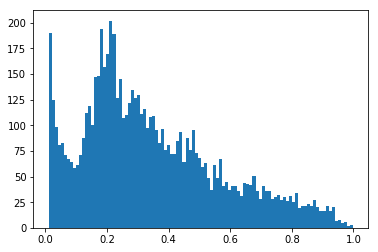

In [6]:
# examine training data to confirm valid capacity factors

print(u"Y data max: {0}, min: {1}".format(y_data.max(),y_data.min()))
plt.hist(y_data,bins=100)
plt.show()

In [7]:
# calculate scaling values for normalizing input data

mean_vals = np.mean(X_data,axis=0)
range_vals = np.max(X_data,axis=0) - np.min(X_data,axis=0)

In [8]:
# set up neural network

INPUT_SHAPE = X_data[0].shape
print(u"Input shape is: {0}".format(INPUT_SHAPE))
DROPOUT_RATE = 0.15
DENSE_LAYER_SIZE = 256

def myNet(activation_type='relu'):
    model = Sequential()
    model.add(Lambda(lambda x: (x-mean_vals)/range_vals, input_shape = INPUT_SHAPE))   # normalization
    model.add(Dense(DENSE_LAYER_SIZE,activation=activation_type))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation=activation_type))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation=activation_type))
    model.add(Dense(1,activation='sigmoid'))    # will restrict output to [0,1]
    return model
    
model = myNet()
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model.count_params()))
print(model.summary())

Input shape is: (6,)
Model contains 133633 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1792      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)      

In [9]:
# fit model

def fit_model(model,weights_file):
    BATCH_SIZE = 64
    NUM_EPOCHS = 512
    early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=64)
    check_point = ModelCheckpoint(weights_file,monitor='val_loss',save_best_only=True,mode='max')
    history_object = model.fit(x=X_data, y=y_data,
                           batch_size = BATCH_SIZE,
                           epochs = NUM_EPOCHS,
                           verbose = 1,
                           callbacks = [early_stop,check_point],
                           validation_split = VALIDATION_FRACTION)
    return history_object
                           
# fit model
history_object = fit_model(model,WEIGHTS_FILE)

# reload model with best weights from training
model = myNet()
model.load_weights(WEIGHTS_FILE)
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")

Train on 5523 samples, validate on 1381 samples
Epoch 1/512
5523/5523 [==============================] - 1s 203us/step - loss: 0.0471 - mean_absolute_error: 0.1709 - val_loss: 0.0450 - val_mean_absolute_error: 0.1705
Epoch 2/512
5523/5523 [==============================] - 1s 102us/step - loss: 0.0386 - mean_absolute_error: 0.1504 - val_loss: 0.0424 - val_mean_absolute_error: 0.1597
Epoch 3/512
5523/5523 [==============================] - 1s 101us/step - loss: 0.0362 - mean_absolute_error: 0.1438 - val_loss: 0.0356 - val_mean_absolute_error: 0.1456
Epoch 4/512
5523/5523 [==============================] - 1s 103us/step - loss: 0.0354 - mean_absolute_error: 0.1426 - val_loss: 0.0326 - val_mean_absolute_error: 0.1338
Epoch 5/512
5523/5523 [==============================] - 1s 101us/step - loss: 0.0350 - mean_absolute_error: 0.1414 - val_loss: 0.0318 - val_mean_absolute_error: 0.1305
Epoch 6/512
5523/5523 [==============================] - 1s 104us/step - loss: 0.0345 - mean_absolute_error

5523/5523 [==============================] - 1s 109us/step - loss: 0.0281 - mean_absolute_error: 0.1233 - val_loss: 0.0275 - val_mean_absolute_error: 0.1201
Epoch 50/512
5523/5523 [==============================] - 1s 145us/step - loss: 0.0275 - mean_absolute_error: 0.1216 - val_loss: 0.0289 - val_mean_absolute_error: 0.1258
Epoch 51/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0277 - mean_absolute_error: 0.1226 - val_loss: 0.0272 - val_mean_absolute_error: 0.1175
Epoch 52/512
5523/5523 [==============================] - 1s 103us/step - loss: 0.0273 - mean_absolute_error: 0.1217 - val_loss: 0.0269 - val_mean_absolute_error: 0.1164
Epoch 53/512
5523/5523 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.121 - 1s 106us/step - loss: 0.0272 - mean_absolute_error: 0.1214 - val_loss: 0.0287 - val_mean_absolute_error: 0.1209
Epoch 54/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0274 - mean_absolute_error:

Epoch 97/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0245 - mean_absolute_error: 0.1134 - val_loss: 0.0289 - val_mean_absolute_error: 0.1197
Epoch 98/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0249 - mean_absolute_error: 0.1146 - val_loss: 0.0285 - val_mean_absolute_error: 0.1194
Epoch 99/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0247 - mean_absolute_error: 0.1136 - val_loss: 0.0285 - val_mean_absolute_error: 0.1192
Epoch 100/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0248 - mean_absolute_error: 0.1139 - val_loss: 0.0282 - val_mean_absolute_error: 0.1172
Epoch 101/512
5523/5523 [==============================] - 1s 112us/step - loss: 0.0250 - mean_absolute_error: 0.1144 - val_loss: 0.0296 - val_mean_absolute_error: 0.1238
Epoch 102/512
5523/5523 [==============================] - 1s 112us/step - loss: 0.0246 - mean_absolute_error: 0.1142 - val_loss: 0.0284 - val_mean_

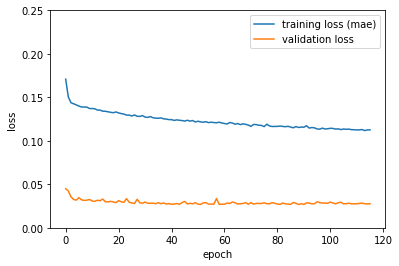

In [10]:
# plot training loss history

def plot_loss(hist_obj):
    plt.plot(hist_obj.history['mean_absolute_error'])
    plt.plot(hist_obj.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss (mae)','validation loss'],loc='upper right')
    plt.ylim([0,0.25])
    plt.show()
    
plot_loss(history_object)

In [11]:
# visualize model

#SVG(model_to_dot(model).create(prog='dot',format='svg'))

Predicted values in range: 6904
Predicted max: 0.573645412922, min: 0.207647696137


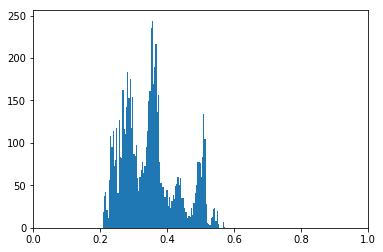

In [12]:
# examine results of model applied to training data

def prediction_histogram(model):
    predicted_values = model.predict(X_data)
    print(u"Predicted values in range: {0}".format(((predicted_values >= 0.0) & (predicted_values <= 1.0)).sum()))
    print(u"Predicted max: {0}, min: {1}".format(predicted_values.max(),predicted_values.min()))
    plt.hist(predicted_values,bins=100)
    plt.xlim(0,1)
    plt.show()
    return predicted_values
    
predicted_values = prediction_histogram(model)

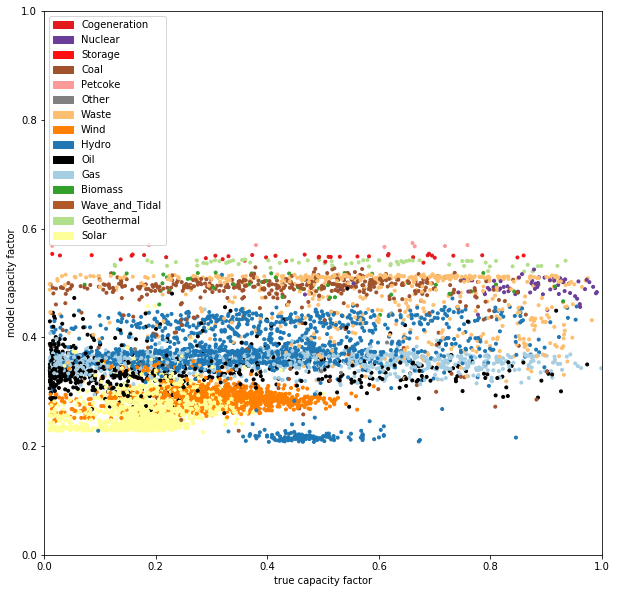

In [13]:
# plot predicted values vs. true values

def plot_predicted(pred_vals):
    label_patches = [mpatches.Patch(color=v,label=k) for k,v in fuel_color.iteritems()]
    fig = plt.figure(figsize=(10,10))
    colors = [fuel_color[fuel1_key[int(c)]] for c in X_data[:,5]]
    plt.scatter(y_data,pred_vals,marker='.',c=colors)
    plt.xlabel('true capacity factor')
    plt.ylabel('model capacity factor')
    plt.legend(handles=label_patches,loc='upper left')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    
plot_predicted(predicted_values)

(-0.5, 616.5, 592.5, -0.5)

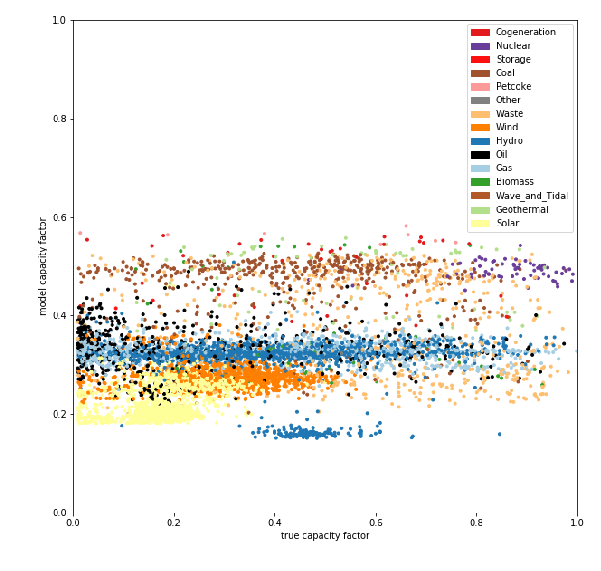

In [14]:
# for comparison show predicted vs true values using a model trained with mean absolute error as loss function

mae_model = io.imread("./images/model1_mae_128.png")
fig = plt.figure(figsize=(10,10))
plt.imshow(mae_model)
plt.axis('off')

In [15]:
# calculate simple r2 for training data, model value

r2_score = metrics.r2_score(y_data,predicted_values)
print(u"R2 score: {0}".format(r2_score))

R2 score: 0.189851925633


In [16]:
# PROBLEM: model mostly predicts capacity factor within a narrow band
# try model with different activation to avoid possible dying relu neuron problem

model2 = myNet(activation_type = 'sigmoid')
model2.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model2.count_params()))
print(model2.summary())

Model contains 133633 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1792      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 1)    

In [19]:
# fit model
WEIGHTS_FILE2 = "model2/estimate_generation.h5"

# fit model
history_object2 = fit_model(model2,WEIGHTS_FILE2)
                           
# reload model with best weights from training
model2 = myNet(activation_type = 'sigmoid')
model2.load_weights(WEIGHTS_FILE2)
model2.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")

Train on 5523 samples, validate on 1381 samples
Epoch 1/512
5523/5523 [==============================] - 1s 192us/step - loss: 0.0517 - mean_absolute_error: 0.1835 - val_loss: 0.0512 - val_mean_absolute_error: 0.1826
Epoch 2/512
5523/5523 [==============================] - 1s 120us/step - loss: 0.0511 - mean_absolute_error: 0.1829 - val_loss: 0.0508 - val_mean_absolute_error: 0.1827
Epoch 3/512
5523/5523 [==============================] - 1s 117us/step - loss: 0.0508 - mean_absolute_error: 0.1823 - val_loss: 0.0522 - val_mean_absolute_error: 0.1814
Epoch 4/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0507 - mean_absolute_error: 0.1811 - val_loss: 0.0500 - val_mean_absolute_error: 0.1836
Epoch 5/512
5523/5523 [==============================] - 1s 102us/step - loss: 0.0503 - mean_absolute_error: 0.1808 - val_loss: 0.0511 - val_mean_absolute_error: 0.1797
Epoch 6/512
5523/5523 [==============================] - 1s 110us/step - loss: 0.0495 - mean_absolute_error

5523/5523 [==============================] - 1s 99us/step - loss: 0.0459 - mean_absolute_error: 0.1678 - val_loss: 0.0520 - val_mean_absolute_error: 0.1787
Epoch 50/512
5523/5523 [==============================] - 1s 101us/step - loss: 0.0458 - mean_absolute_error: 0.1676 - val_loss: 0.0493 - val_mean_absolute_error: 0.1814
Epoch 51/512
5523/5523 [==============================] - 1s 98us/step - loss: 0.0460 - mean_absolute_error: 0.1675 - val_loss: 0.0494 - val_mean_absolute_error: 0.1807
Epoch 52/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0455 - mean_absolute_error: 0.1669 - val_loss: 0.0493 - val_mean_absolute_error: 0.1799
Epoch 53/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0459 - mean_absolute_error: 0.1679 - val_loss: 0.0489 - val_mean_absolute_error: 0.1787
Epoch 54/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0455 - mean_absolute_error: 0.1667 - val_loss: 0.0504 - val_mean_absolute_error: 0.17

5523/5523 [==============================] - 1s 98us/step - loss: 0.0432 - mean_absolute_error: 0.1617 - val_loss: 0.0437 - val_mean_absolute_error: 0.1641
Epoch 98/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0426 - mean_absolute_error: 0.1599 - val_loss: 0.0431 - val_mean_absolute_error: 0.1640
Epoch 99/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0432 - mean_absolute_error: 0.1613 - val_loss: 0.0434 - val_mean_absolute_error: 0.1636
Epoch 100/512
5523/5523 [==============================] - 1s 96us/step - loss: 0.0433 - mean_absolute_error: 0.1615 - val_loss: 0.0454 - val_mean_absolute_error: 0.1645
Epoch 101/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0434 - mean_absolute_error: 0.1619 - val_loss: 0.0433 - val_mean_absolute_error: 0.1650
Epoch 102/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0432 - mean_absolute_error: 0.1606 - val_loss: 0.0435 - val_mean_absolute_error: 0

5523/5523 [==============================] - 1s 100us/step - loss: 0.0401 - mean_absolute_error: 0.1541 - val_loss: 0.0365 - val_mean_absolute_error: 0.1450
Epoch 146/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0397 - mean_absolute_error: 0.1532 - val_loss: 0.0366 - val_mean_absolute_error: 0.1448
Epoch 147/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0393 - mean_absolute_error: 0.1521 - val_loss: 0.0358 - val_mean_absolute_error: 0.1431
Epoch 148/512
5523/5523 [==============================] - 1s 101us/step - loss: 0.0391 - mean_absolute_error: 0.1517 - val_loss: 0.0365 - val_mean_absolute_error: 0.1436
Epoch 149/512
5523/5523 [==============================] - 1s 98us/step - loss: 0.0393 - mean_absolute_error: 0.1525 - val_loss: 0.0373 - val_mean_absolute_error: 0.1462
Epoch 150/512
5523/5523 [==============================] - 1s 121us/step - loss: 0.0396 - mean_absolute_error: 0.1526 - val_loss: 0.0357 - val_mean_absolute_error

5523/5523 [==============================] - 1s 98us/step - loss: 0.0384 - mean_absolute_error: 0.1502 - val_loss: 0.0346 - val_mean_absolute_error: 0.1392
Epoch 194/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0383 - mean_absolute_error: 0.1497 - val_loss: 0.0348 - val_mean_absolute_error: 0.1397
Epoch 195/512
5523/5523 [==============================] - 1s 96us/step - loss: 0.0382 - mean_absolute_error: 0.1491 - val_loss: 0.0348 - val_mean_absolute_error: 0.1397
Epoch 196/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0384 - mean_absolute_error: 0.1496 - val_loss: 0.0348 - val_mean_absolute_error: 0.1393
Epoch 197/512
5523/5523 [==============================] - 1s 98us/step - loss: 0.0385 - mean_absolute_error: 0.1498 - val_loss: 0.0370 - val_mean_absolute_error: 0.1465
Epoch 198/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0380 - mean_absolute_error: 0.1494 - val_loss: 0.0346 - val_mean_absolute_error:

5523/5523 [==============================] - 1s 98us/step - loss: 0.0375 - mean_absolute_error: 0.1477 - val_loss: 0.0343 - val_mean_absolute_error: 0.1398
Epoch 242/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0373 - mean_absolute_error: 0.1471 - val_loss: 0.0351 - val_mean_absolute_error: 0.1418
Epoch 243/512
5523/5523 [==============================] - 1s 96us/step - loss: 0.0372 - mean_absolute_error: 0.1473 - val_loss: 0.0335 - val_mean_absolute_error: 0.1363
Epoch 244/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0373 - mean_absolute_error: 0.1475 - val_loss: 0.0340 - val_mean_absolute_error: 0.1384
Epoch 245/512
5523/5523 [==============================] - 1s 98us/step - loss: 0.0374 - mean_absolute_error: 0.1476 - val_loss: 0.0336 - val_mean_absolute_error: 0.1364
Epoch 246/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0376 - mean_absolute_error: 0.1479 - val_loss: 0.0343 - val_mean_absolute_error:

5523/5523 [==============================] - 1s 97us/step - loss: 0.0365 - mean_absolute_error: 0.1446 - val_loss: 0.0335 - val_mean_absolute_error: 0.1352
Epoch 290/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0364 - mean_absolute_error: 0.1442 - val_loss: 0.0330 - val_mean_absolute_error: 0.1341
Epoch 291/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0367 - mean_absolute_error: 0.1452 - val_loss: 0.0337 - val_mean_absolute_error: 0.1382
Epoch 292/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0366 - mean_absolute_error: 0.1454 - val_loss: 0.0330 - val_mean_absolute_error: 0.1347
Epoch 293/512
5523/5523 [==============================] - 1s 100us/step - loss: 0.0366 - mean_absolute_error: 0.1445 - val_loss: 0.0338 - val_mean_absolute_error: 0.1388
Epoch 294/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0365 - mean_absolute_error: 0.1448 - val_loss: 0.0332 - val_mean_absolute_error:

5523/5523 [==============================] - 1s 107us/step - loss: 0.0357 - mean_absolute_error: 0.1424 - val_loss: 0.0321 - val_mean_absolute_error: 0.1323
Epoch 338/512
5523/5523 [==============================] - 1s 104us/step - loss: 0.0359 - mean_absolute_error: 0.1429 - val_loss: 0.0320 - val_mean_absolute_error: 0.1321
Epoch 339/512
5523/5523 [==============================] - 1s 104us/step - loss: 0.0357 - mean_absolute_error: 0.1425 - val_loss: 0.0319 - val_mean_absolute_error: 0.1311
Epoch 340/512
5523/5523 [==============================] - 1s 111us/step - loss: 0.0355 - mean_absolute_error: 0.1420 - val_loss: 0.0325 - val_mean_absolute_error: 0.1346
Epoch 341/512
5523/5523 [==============================] - 1s 123us/step - loss: 0.0355 - mean_absolute_error: 0.1413 - val_loss: 0.0331 - val_mean_absolute_error: 0.1372
Epoch 342/512
5523/5523 [==============================] - 1s 104us/step - loss: 0.0356 - mean_absolute_error: 0.1416 - val_loss: 0.0320 - val_mean_absolute_er

Epoch 385/512
5523/5523 [==============================] - 1s 99us/step - loss: 0.0348 - mean_absolute_error: 0.1398 - val_loss: 0.0315 - val_mean_absolute_error: 0.1305
Epoch 386/512
5523/5523 [==============================] - 1s 97us/step - loss: 0.0346 - mean_absolute_error: 0.1397 - val_loss: 0.0313 - val_mean_absolute_error: 0.1292
Epoch 387/512
5523/5523 [==============================] - 1s 103us/step - loss: 0.0350 - mean_absolute_error: 0.1406 - val_loss: 0.0325 - val_mean_absolute_error: 0.1331
Epoch 388/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0349 - mean_absolute_error: 0.1401 - val_loss: 0.0324 - val_mean_absolute_error: 0.1343
Epoch 389/512
5523/5523 [==============================] - 1s 103us/step - loss: 0.0350 - mean_absolute_error: 0.1406 - val_loss: 0.0326 - val_mean_absolute_error: 0.1344
Epoch 390/512
5523/5523 [==============================] - 1s 95us/step - loss: 0.0349 - mean_absolute_error: 0.1406 - val_loss: 0.0316 - val_mean_

Epoch 433/512
5523/5523 [==============================] - 1s 143us/step - loss: 0.0342 - mean_absolute_error: 0.1384 - val_loss: 0.0311 - val_mean_absolute_error: 0.1300
Epoch 434/512
5523/5523 [==============================] - 1s 125us/step - loss: 0.0343 - mean_absolute_error: 0.1393 - val_loss: 0.0310 - val_mean_absolute_error: 0.1291
Epoch 435/512
5523/5523 [==============================] - 1s 114us/step - loss: 0.0342 - mean_absolute_error: 0.1385 - val_loss: 0.0311 - val_mean_absolute_error: 0.1302
Epoch 436/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0341 - mean_absolute_error: 0.1387 - val_loss: 0.0311 - val_mean_absolute_error: 0.1302
Epoch 437/512
5523/5523 [==============================] - 1s 124us/step - loss: 0.0342 - mean_absolute_error: 0.1389 - val_loss: 0.0312 - val_mean_absolute_error: 0.1299
Epoch 438/512
5523/5523 [==============================] - 1s 116us/step - loss: 0.0337 - mean_absolute_error: 0.1377 - val_loss: 0.0307 - val_me

Epoch 481/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0328 - mean_absolute_error: 0.1353 - val_loss: 0.0301 - val_mean_absolute_error: 0.1260
Epoch 482/512
5523/5523 [==============================] - 1s 107us/step - loss: 0.0331 - mean_absolute_error: 0.1360 - val_loss: 0.0303 - val_mean_absolute_error: 0.1262
Epoch 483/512
5523/5523 [==============================] - 1s 107us/step - loss: 0.0330 - mean_absolute_error: 0.1354 - val_loss: 0.0306 - val_mean_absolute_error: 0.1278
Epoch 484/512
5523/5523 [==============================] - 1s 106us/step - loss: 0.0331 - mean_absolute_error: 0.1359 - val_loss: 0.0303 - val_mean_absolute_error: 0.1273
Epoch 485/512
5523/5523 [==============================] - 1s 105us/step - loss: 0.0330 - mean_absolute_error: 0.1354 - val_loss: 0.0307 - val_mean_absolute_error: 0.1287
Epoch 486/512
5523/5523 [==============================] - 1s 103us/step - loss: 0.0330 - mean_absolute_error: 0.1359 - val_loss: 0.0311 - val_me

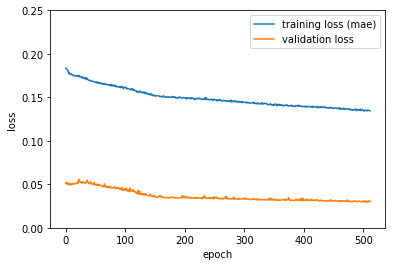

Predicted values in range: 6904
Predicted max: 0.525287032127, min: 0.178858473897


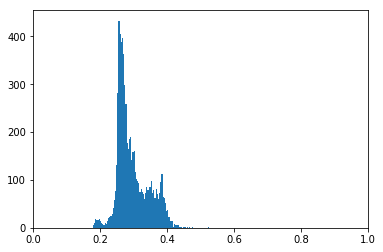

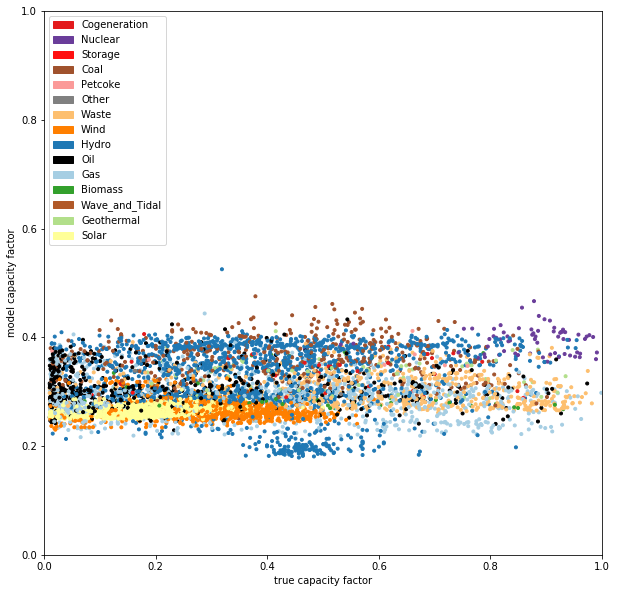

R2 score: 0.00593649236261


In [20]:
# examine model fit results
    
plot_loss(history_object2)
predicted_values2 = prediction_histogram(model2)
plot_predicted(predicted_values2)
r2_score = metrics.r2_score(y_data,predicted_values2)
print(u"R2 score: {0}".format(r2_score))

In [21]:
# conclusion: not much better
# try LeakyReLU 
# PROBLEM: Error with LeakyReLU and Keras/Tensorflow backend
# https://github.com/keras-team/keras/issues/9349

RELU_LEAKAGE = 0.2

def myNet_Leaky():
    model = Sequential()
    model.add(Lambda(lambda x: (x-mean_vals)/range_vals, input_shape = INPUT_SHAPE))   # normalization
    model.add(Dense(DENSE_LAYER_SIZE,activation='linear'))
    model.add(LeakyReLU(alpha=RELU_LEAKAGE))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='linear'))
    model.add(LeakyReLU(alpha=RELU_LEAKAGE))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='linear'))
    model.add(LeakyReLU(alpha=RELU_LEAKAGE))
    model.add(Dense(1,activation='sigmoid'))    # will restrict output to [0,1]
    return model
    
model3 = myNet_Leaky()
model3.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model3.count_params()))
print(model3.summary())

Model contains 133633 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)  

In [22]:
# fit model
WEIGHTS_FILE3 = "model3/estimate_generation.h5"

# fit model
history_object3 = fit_model(model3,WEIGHTS_FILE3)
                           
# reload model with best weights from training
model3 = myNet_Leaky()
model3.load_weights(WEIGHTS_FILE3)
model3.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")

Train on 5523 samples, validate on 1381 samples
Epoch 1/512
5523/5523 [==============================] - 1s 235us/step - loss: 0.0472 - mean_absolute_error: 0.1712 - val_loss: 0.0484 - val_mean_absolute_error: 0.1745
Epoch 2/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0406 - mean_absolute_error: 0.1555 - val_loss: 0.0386 - val_mean_absolute_error: 0.1526
Epoch 3/512
5523/5523 [==============================] - 1s 107us/step - loss: 0.0380 - mean_absolute_error: 0.1487 - val_loss: 0.0347 - val_mean_absolute_error: 0.1407
Epoch 4/512
5523/5523 [==============================] - 1s 107us/step - loss: 0.0370 - mean_absolute_error: 0.1462 - val_loss: 0.0341 - val_mean_absolute_error: 0.1396
Epoch 5/512
5523/5523 [==============================] - 1s 107us/step - loss: 0.0360 - mean_absolute_error: 0.1436 - val_loss: 0.0331 - val_mean_absolute_error: 0.1344
Epoch 6/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0358 - mean_absolute_error

Epoch 49/512
5523/5523 [==============================] - 1s 130us/step - loss: 0.0312 - mean_absolute_error: 0.1323 - val_loss: 0.0299 - val_mean_absolute_error: 0.1290
Epoch 50/512
5523/5523 [==============================] - 1s 125us/step - loss: 0.0304 - mean_absolute_error: 0.1303 - val_loss: 0.0281 - val_mean_absolute_error: 0.1228
Epoch 51/512
5523/5523 [==============================] - 1s 118us/step - loss: 0.0306 - mean_absolute_error: 0.1312 - val_loss: 0.0307 - val_mean_absolute_error: 0.1327
Epoch 52/512
5523/5523 [==============================] - 1s 108us/step - loss: 0.0307 - mean_absolute_error: 0.1316 - val_loss: 0.0291 - val_mean_absolute_error: 0.1246
Epoch 53/512
5523/5523 [==============================] - 1s 119us/step - loss: 0.0310 - mean_absolute_error: 0.1320 - val_loss: 0.0305 - val_mean_absolute_error: 0.1331
Epoch 54/512
5523/5523 [==============================] - 1s 116us/step - loss: 0.0308 - mean_absolute_error: 0.1315 - val_loss: 0.0304 - val_mean_abs

5523/5523 [==============================] - 1s 121us/step - loss: 0.0290 - mean_absolute_error: 0.1263 - val_loss: 0.0283 - val_mean_absolute_error: 0.1242
Epoch 98/512
5523/5523 [==============================] - 1s 114us/step - loss: 0.0292 - mean_absolute_error: 0.1275 - val_loss: 0.0310 - val_mean_absolute_error: 0.1310
Epoch 99/512
5523/5523 [==============================] - 1s 174us/step - loss: 0.0293 - mean_absolute_error: 0.1273 - val_loss: 0.0339 - val_mean_absolute_error: 0.1407
Epoch 100/512
5523/5523 [==============================] - 1s 121us/step - loss: 0.0287 - mean_absolute_error: 0.1263 - val_loss: 0.0286 - val_mean_absolute_error: 0.1263
Epoch 101/512
5523/5523 [==============================] - 1s 114us/step - loss: 0.0292 - mean_absolute_error: 0.1273 - val_loss: 0.0309 - val_mean_absolute_error: 0.1330
Epoch 102/512
5523/5523 [==============================] - 1s 110us/step - loss: 0.0288 - mean_absolute_error: 0.1260 - val_loss: 0.0333 - val_mean_absolute_erro

5523/5523 [==============================] - 1s 108us/step - loss: 0.0276 - mean_absolute_error: 0.1224 - val_loss: 0.0317 - val_mean_absolute_error: 0.1332
Epoch 146/512
5523/5523 [==============================] - 1s 106us/step - loss: 0.0280 - mean_absolute_error: 0.1247 - val_loss: 0.0288 - val_mean_absolute_error: 0.1254
Epoch 147/512
5523/5523 [==============================] - 1s 109us/step - loss: 0.0275 - mean_absolute_error: 0.1225 - val_loss: 0.0283 - val_mean_absolute_error: 0.1220
Finished training; model reloaded with optimum weights.


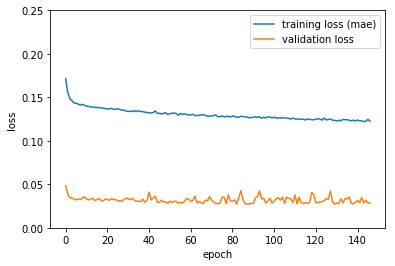

Predicted values in range: 6904
Predicted max: 0.690942883492, min: 0.179257959127


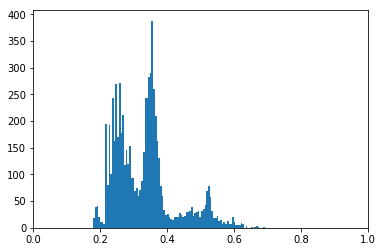

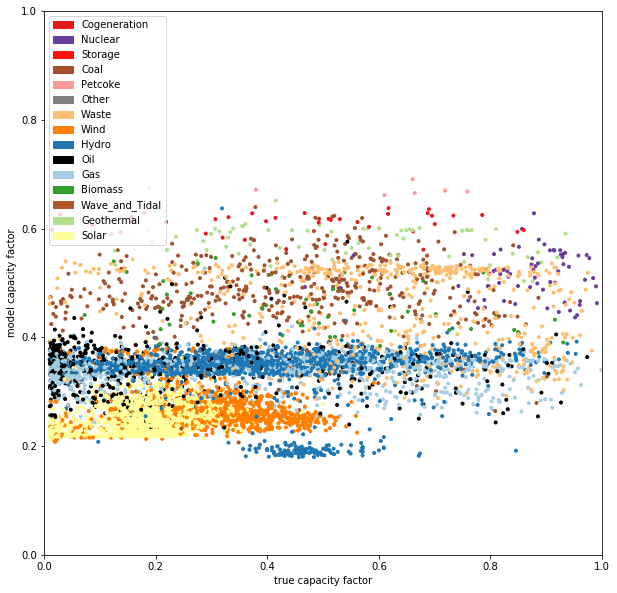

R2 score: 0.153435372515


In [23]:
# examine model fit results
    
plot_loss(history_object3)
predicted_values3 = prediction_histogram(model3)
plot_predicted(predicted_values3)
r2_score = metrics.r2_score(y_data,predicted_values3)
print(u"R2 score: {0}".format(r2_score))